# Assignment 5: Logistic Regression with Variable Selection

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking **'Runtime' > 'Restart session and run all'**.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

# Dataset

In this assignment, you will work on a dataset taken from USGS(U.S Geological Survey). This dataset contains earthquake data with a magnitude of 4.5+ and an "alert" warning level, recorded between 1976 and 2025. Below is an explanation of the columns included in the dataset:

- **`id`**: A unique identifier for the earthquake event.
- **`time`**: The timestamp indicating when the earthquake or event occurred, including the date and time in UTC format.
- **`latitude`**: The geographical latitude of the earthquake's epicenter, measured in degrees.
- **`longitude`**: The geographical longitude of the earthquake's epicenter, measured in degrees.
- **`depth`**: The depth at which the earthquake occurred, typically measured in kilometers below the Earth's surface.
- **`mag`**: The magnitude of the earthquake, representing the energy released by the seismic event. In this case, a value of 8.6 indicates a very large earthquake.
- **`gap`**: The azimuthal gap, which refers to the angular distance between the two most distant seismic stations that recorded the earthquake. A smaller gap typically indicates better global coverage.
- **`dmin`**: The minimum distance between the earthquake's epicenter and the nearest seismic station, measured in degrees.
- **`rms`**: The root mean square of the amplitude of the seismic waves, representing the strength of the seismic signal.
- **`horizontalError`**: The error associated with the latitude and longitude coordinates of the epicenter, typically measured in kilometers.
- **`depthError`**: The error associated with the depth measurement of the earthquake, typically measured in kilometers.
- **`magError`**: The error associated with the magnitude measurement of the earthquake, representing the uncertainty in the reported magnitude.
- **`magNst`**: The number of stations that contributed to the magnitude estimation.
- **`Alert` (target)** The alert level issued for the earthquake, whether 'Severe' or 'Non-Severe'.

The goal is to train a model for predicting the **`Alert`** which indicates the severity of the earthquake.



In [ ]:
# Standard imports
import numpy as np
from itertools import chain, combinations

# Data manipulation
import pandas as pd
import polars as pl

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Download the data
# !gdown https://drive.google.com/uc?id=1yL84FMQrfHC_cQsa_V3KTcRAJS0k4DhY

# Part 1: Data Preprocessing

## Question 1.1: Load data

(1) Read the **`earthquakes.parquet`** file as a **`polars.DataFrame`** and show its descriptive statistics.

(2) Drop column **`id`** and **`time`** and display the first 5 rows of the dataframe.

Since **`id`** is unique for each earthquake event that does not contain any predictive information and **`time`** is not directly informative for predicting earthquake severity unless you extract relevant features such as time of day, seasonality, etc.

In [3]:
# (1) YOUR CODE HERE
df = pl.read_parquet("earthquakes.parquet")


In [4]:
# (2) YOUR CODE HERE

df = df.drop(["id", "time"])
display(df)

latitude,longitude,depth,mag,gap,dmin,rms,horizontalError,depthError,magError,magNst,Alert
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
35.59,-90.48,15.0,4.62,null,null,null,null,null,null,0.0,"""Non-Severe"""
32.998667,-115.5575,14.19,5.8,79.0,0.05768,0.17,1.03,1.78,null,0.0,"""Severe"""
38.19,-83.95,10.0,5.0,null,null,null,null,null,null,null,"""Non-Severe"""
35.816,-117.816333,4.766,4.7,135.0,null,0.66,2.51,31.61,0.424,9.0,"""Non-Severe"""
33.0955,-115.6245,18.904,5.75,34.0,null,0.34,0.56,0.67,0.161,6.0,"""Non-Severe"""
…,…,…,…,…,…,…,…,…,…,…,…
-56.3574,147.017,10.0,5.7,109.0,13.462,0.62,12.18,1.916,0.056,31.0,"""Non-Severe"""
-11.7513,166.1708,25.375,5.4,114.0,6.535,0.86,10.36,5.288,0.062,25.0,"""Non-Severe"""
-17.7098,168.0292,46.0,6.1,32.0,4.528,0.55,8.73,1.944,0.038,66.0,"""Non-Severe"""


## Question 1.2: Handle null values

The result of the `null_count` function indicates that some columns contain null values. Fill these null values with the median of the corresponding column and display the first 5 rows of the resulting dataframe.

In [5]:
df.null_count() # uncomment and run this code

latitude,longitude,depth,mag,gap,dmin,rms,horizontalError,depthError,magError,magNst,Alert
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,324,702,26,1218,209,2214,2067,0


In [6]:
numeric_types = (pl.Int32, pl.Int64, pl.Float32, pl.Float64)

for c in df.columns:
    if df.schema[c] not in numeric_types:
        continue

    median_value = df.select(pl.col(c).median()).to_series()[0]
    df = df.with_columns(pl.col(c).fill_null(median_value))

df.head()

latitude,longitude,depth,mag,gap,dmin,rms,horizontalError,depthError,magError,magNst,Alert
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
35.59,-90.48,15.0,4.62,38.0,2.407,0.82,7.1,1.8,0.059,0.0,"""Non-Severe"""
32.998667,-115.5575,14.19,5.8,79.0,0.05768,0.17,1.03,1.78,0.059,0.0,"""Severe"""
38.19,-83.95,10.0,5.0,38.0,2.407,0.82,7.1,1.8,0.059,29.0,"""Non-Severe"""
35.816,-117.816333,4.766,4.7,135.0,2.407,0.66,2.51,31.61,0.424,9.0,"""Non-Severe"""
33.0955,-115.6245,18.904,5.75,34.0,2.407,0.34,0.56,0.67,0.161,6.0,"""Non-Severe"""


## Question 1.3: Explore target distribution

Count the number of instances of each severity level of the earthquake in the dataset.

Comment on your findings, providing insights into the distribution of different severity levels.

shape: (2, 2)
┌────────────┬───────┐
│ Alert      ┆ count │
│ ---        ┆ ---   │
│ str        ┆ u32   │
╞════════════╪═══════╡
│ Non-Severe ┆ 7368  │
│ Severe     ┆ 331   │
└────────────┴───────┘


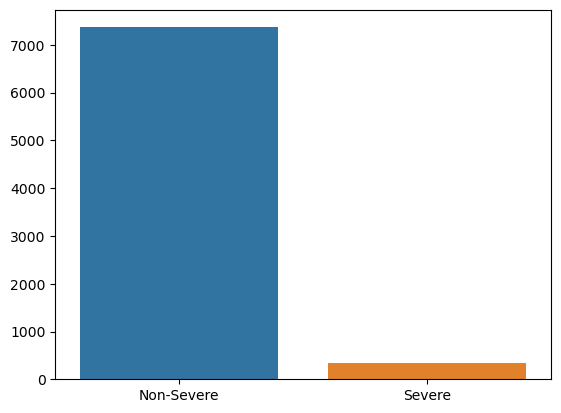

In [7]:
# YOUR CODE HERE
histogram = df["Alert"].value_counts()
graph = sns.barplot(x=histogram["Alert"].to_list(), y=histogram["count"].to_list())
print(histogram)

Most earthquakes are non-severe. So this makes sense.

## Question 1.4: Convert target variable

Convert **`Alert`** to a binary numerical target:
- Replace **`Severe`** with 1.
- Replace **`Non-Severe`** with 0.

Display the first 5 rows of the resulting dataframe.

Hint: If you use the `replace` method, the resulting column will still be of string type. Use `cast` to make it `Float64` after replacement.

In [8]:
# YOUR CODE HERE
df = df.with_columns(
	pl.when(pl.col("Alert") == "Non-Severe").then(0)
	  .when(pl.col("Alert") == "Severe").then(1)
	  .otherwise(pl.col("Alert"))
	  .alias("Alert")
)
df = df.cast({"Alert": pl.Float64})
print(df["Alert"].dtype)

Float64


## Question 1.5: Train test split

Split the dataset into training and testing sets:
- With **30% testing data** and **70% training data**.
- Set the **random state** to **2025**.
- Use **stratified splitting** to **maintain the same proportion of each class** in the target variable (**`Alert`**) in both the training and testing sets.

Display the descriptive statistics for X_train and X_test.

In [9]:
X = df.drop(["Alert"])
y = df[c]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=2025, stratify=y
)

print("X_train descriptive statistics:")
print(X_train.describe())

print("\nX_test descriptive statistics:")
print(X_test.describe())

X_train descriptive statistics:
shape: (9, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬──────────┬───────────┐
│ statistic ┆ latitude  ┆ longitude ┆ depth     ┆ … ┆ horizonta ┆ depthErro ┆ magError ┆ magNst    │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ lError    ┆ r         ┆ ---      ┆ ---       │
│ str       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ f64      ┆ f64       │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆          ┆           │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪══════════╪═══════════╡
│ count     ┆ 5389.0    ┆ 5389.0    ┆ 5389.0    ┆ … ┆ 5389.0    ┆ 5389.0    ┆ 5389.0   ┆ 5389.0    │
│ null_coun ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0      ┆ 0.0       │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆          ┆           │
│ mean      ┆ 1.196909  ┆ 14.828723 ┆ 58.076

# Part 2: Sequential Feature Selection

## Question 2.1: Forward Selection

Create a pipeline using [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) to perform **forward** feature selection:
- Standardize the data, ensuring each feature has a mean of 0 and a standard deviation of 1.
- Use **ROC AUC** as the scoring metric for feature selection. Conduct **5-fold cross-validation** to evaluate the model. Set the **tolerance for stopping** the selection process to **0.001**.
- Configure the logistic regression to use the default **`lbfgs`** as solver with **no penalty**. Set the **maximum number of iterations** to **1000**. Use a **balanced** weight that adjust weights inversely proportional to class frequencies in the input data. Set the **random state** to **2025**.

Fit the pipeline and report the subset of variables on this method.


In [10]:
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        penalty=None,
        solver="lbfgs",
        max_iter=1000,
        class_weight="balanced",
        random_state=2025
    ))
])
 
sfs_forward = SequentialFeatureSelector(
    estimator=pipe_lr,
    n_features_to_select=5,
    direction="forward",
    scoring="roc_auc",
    cv=5,
    tol=0.001
)

sfs_forward.fit(X_train, y_train)

SequentialFeatureSelector(estimator=Pipeline(steps=[('scaler',
                                                     StandardScaler()),
                                                    ('lr',
                                                     LogisticRegression(class_weight='balanced',
                                                                        max_iter=1000,
                                                                        penalty=None,
                                                                        random_state=2025))]),
                          n_features_to_select=5, scoring='roc_auc', tol=0.001)

## Question 2.2: Backward Selection

Create a pipeline using [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) to perform **backward** feature selection. Keep all other configurations the same as in the previous question

Fit the pipeline and report the subset of variables on this method.


In [11]:
sfs_backward = SequentialFeatureSelector(
    estimator=pipe_lr,
    n_features_to_select=5,
    direction="backward",
    scoring="roc_auc",
    cv=5,
    tol=0.001
)

sfs_backward.fit(X_train, y_train)


SequentialFeatureSelector(direction='backward',
                          estimator=Pipeline(steps=[('scaler',
                                                     StandardScaler()),
                                                    ('lr',
                                                     LogisticRegression(class_weight='balanced',
                                                                        max_iter=1000,
                                                                        penalty=None,
                                                                        random_state=2025))]),
                          n_features_to_select=5, scoring='roc_auc', tol=0.001)

In [12]:
print(sfs_backward.get_feature_names_out())
print(sfs_forward.get_feature_names_out())


['latitude' 'depth' 'mag' 'dmin' 'horizontalError']
['latitude' 'depth' 'mag' 'dmin' 'horizontalError']


## Question 2.3: Compare results & find the best model

Compare and discuss the selected subset of variables obtained from both methods used in the previous steps.

Perform an **exhaustive search** over all possible subsets of the remaining variables using **5-fold cross-validation** to find the best model. Use the same Logistic Regression configurations as in previous questions.

Hint: If you have correctly followed the previous steps, you should have **five remaining variables** to evaluate in the exhaustive search.

Among all 11 variables, forward selection resulted in 5 features, while backward selection selected 10 features. This indicates that backward selection retains more variables, perhaps due to its nature of removing less impactful features instead of building up the model iteratively. Both selection results agree on keeping `['latitude', 'depth', 'mag', 'dmin', 'horizontalError']`. We should then conduct an exhaustive search using the remaining five variables `['longitude', 'gap', 'depthError', 'magError', 'magNst']`.

In [ ]:
def best_subset_cv(estimator, X, y, cv=3):
    n_features = X.shape[1]
    subsets = chain.from_iterable(
        combinations(range(n_features), k) for k in range(1, n_features + 1)
    )

    best_score = -np.inf
    best_subset = None
    for subset in subsets:
        score = cross_val_score(estimator, X[:, subset], y, cv=cv).mean()
        if score > best_score:
            best_score, best_subset = score, subset

    return best_subset, best_score

efs = best_subset_cv(pipe_lr, X_train, y_train, cv=5)
print("Best feature subset:", efs[0])
print("Best CV score:", efs[1])


Best feature subset: (0, 2, 3, 4, 5, 6, 7, 8, 10)
Best CV score: 0.8049736177074021


In [ ]:
indices = pl.nth(efs[0])
X_train_selected = X_train.select(indices)


shape: (5_389, 9)
┌──────────┬───────┬─────┬──────┬───┬──────┬─────────────────┬────────────┬────────┐
│ latitude ┆ depth ┆ mag ┆ gap  ┆ … ┆ rms  ┆ horizontalError ┆ depthError ┆ magNst │
│ ---      ┆ ---   ┆ --- ┆ ---  ┆   ┆ ---  ┆ ---             ┆ ---        ┆ ---    │
│ f64      ┆ f64   ┆ f64 ┆ f64  ┆   ┆ f64  ┆ f64             ┆ f64        ┆ f64    │
╞══════════╪═══════╪═════╪══════╪═══╪══════╪═════════════════╪════════════╪════════╡
│ 30.7269  ┆ 11.0  ┆ 5.8 ┆ 14.0 ┆ … ┆ 0.73 ┆ 6.4             ┆ 1.7        ┆ 37.0   │
│ -8.467   ┆ 20.0  ┆ 5.9 ┆ 19.3 ┆ … ┆ 0.95 ┆ 7.1             ┆ 1.8        ┆ 29.0   │
│ -13.69   ┆ 93.0  ┆ 6.2 ┆ 63.0 ┆ … ┆ 0.65 ┆ 7.6             ┆ 1.9        ┆ 58.0   │
│ 26.56    ┆ 15.0  ┆ 6.1 ┆ 33.1 ┆ … ┆ 0.82 ┆ 7.1             ┆ 1.8        ┆ 29.0   │
│ 58.4207  ┆ 10.0  ┆ 5.5 ┆ 67.0 ┆ … ┆ 0.88 ┆ 5.2             ┆ 1.8        ┆ 39.0   │
│ …        ┆ …     ┆ …   ┆ …    ┆ … ┆ …    ┆ …               ┆ …          ┆ …      │
│ -16.3993 ┆ 10.0  ┆ 5.5 ┆ 61.0 ┆ … ┆ 0.59 ┆ 9.

## Question 2.4: Fit the best model

Train a logistic regression model with the best variables selected.

Display the model's coefficients and intercept.

In [ ]:
selected_pipeline_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        penalty=None,
        solver="lbfgs",
        max_iter=1000,
        class_weight="balanced",
        random_state=2025
    ))
])

selected_pipeline_lr.fit(X_train_selected, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    penalty=None, random_state=2025))])

In [85]:
print("Coef and intercept:", selected_pipeline_lr.named_steps["lr"].coef_, selected_pipeline_lr.named_steps["lr"].intercept_)


Coef and intercept: [[ 1.08214921 -2.76496174  1.31613646 -0.47747489 -0.91453408 -0.10713656
  -0.45793564  0.27368793 -0.17824216]] [-2.15305964]


## Question 2.5: Measure model's performance

Construct a **95% confidence interval** for both accuracy and AUC using **100 bootstrap resamples** of the test set.

In [87]:
np.random.seed(2025) 

def bootstrap_confidence_interval(y_true, y_pred, y_pred_proba, 
                                  n_bootstraps=100, confidence=0.95, 
                                  random_state=42):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_proba = np.array(y_pred_proba)
    
    boot_acc = []
    boot_auc = []
    rng = np.random.RandomState(random_state)
    n_samples = len(y_true)
    
    for i in range(n_bootstraps):
        indices = rng.choice(np.arange(n_samples), size=n_samples, replace=True)
        y_true_bs = y_true[indices]
        y_pred_bs = y_pred[indices]
        y_pred_proba_bs = y_pred_proba[indices]
        
        acc = accuracy_score(y_true_bs, y_pred_bs)
        boot_acc.append(acc)
        
        if len(np.unique(y_true_bs)) < 2:
            continue
        auc = roc_auc_score(y_true_bs, y_pred_proba_bs)
        boot_auc.append(auc)
    
    lower_pct = ((1 - confidence) / 2) * 100
    upper_pct = (confidence + (1 - confidence) / 2) * 100
    
    acc_lower = np.percentile(boot_acc, lower_pct)
    acc_upper = np.percentile(boot_acc, upper_pct)
    
    auc_lower = np.percentile(boot_auc, lower_pct)
    auc_upper = np.percentile(boot_auc, upper_pct)
    
    return (acc_lower, acc_upper), (auc_lower, auc_upper)

In [ ]:
bci1 = bootstrap_confidence_interval(y_test, selected_pipeline_lr.predict(X_test.select(indices)), selected_pipeline_lr.predict_proba(X_test.select(indices))[:, 1])
print("Bootstrap confidence interval for accuracy:", bci1[0])
print("Bootstrap confidence interval for AUC:", bci1[1])


Bootstrap confidence interval for accuracy: (0.7880844155844156, 0.8182034632034632)
Bootstrap confidence interval for AUC: (0.851138029496924, 0.90583847065)
0.8778558995655332


# Part 3: Regularization

## Question 3.1: Ridge penalization

Create a pipeline using [`LogisticRegressionCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) to implement a logistic regression with **Ridge penalization**:
- Standardize the data, ensuring each feature has a mean of 0 and a standard deviation of 1.
- Configure the **`LogisticRegressionCV`** to use **`saga`** as solver. Use the default **`Cs = 10`**. Set the **maximum number of iterations** to **1000**. Use a **balanced** weight that adjust weights inversely proportional to class frequencies in the input data. Set the **random state** to **2025**. Use **5-fold cross-validation**.

Fit the pipeline to get the best model.

Construct a **95% confidence interval** for both accuracy and AUC using **100 bootstrap resamples** of the test set.

In [90]:
np.random.seed(2025) # DO NOT DELETE

ridge_pl = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", LogisticRegressionCV(
        penalty="l2",
        solver="saga",
        max_iter=1000,
        class_weight="balanced",
        random_state=2025,
        Cs=10,
        cv=5,
    ))
])

ridge_pl.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 LogisticRegressionCV(class_weight='balanced', cv=5,
                                      max_iter=1000, random_state=2025,
                                      solver='saga'))])

In [92]:
bci2 = bootstrap_confidence_interval(y_test, ridge_pl.predict(X_test), ridge_pl.predict_proba(X_test)[:, 1])
print("Bootstrap confidence interval for accuracy:", bci2[0])
print("Bootstrap confidence interval for AUC:", bci2[1])

Bootstrap confidence interval for accuracy: (0.7837337662337662, 0.8167207792207792)
Bootstrap confidence interval for AUC: (0.8533787712329062, 0.9056525417790737)


## Question 3.2: Lasso penalization

Create a pipeline using [`LogisticRegressionCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) to implement a logistic regression with **Lasso penalization**:
- Standardize the data, ensuring each feature has a mean of 0 and a standard deviation of 1.
- Configure the **`LogisticRegressionCV`** to use **`saga`** as solver. Use the default **`Cs = 10`**. Set the **maximum number of iterations** to **1000**. Use a **balanced** weight that adjust weights inversely proportional to class frequencies in the input data. Set the **random state** to **2025**. Use **5-fold cross-validation**.

Fit the pipeline to get the best model.

Construct a **95% confidence interval** for both accuracy and AUC using **100 bootstrap resamples** of the test set.

In [93]:
np.random.seed(2025) # DO NOT DELETE

lasso_pl = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", LogisticRegressionCV(
        penalty="l1",
        solver="saga",
        max_iter=1000,
        class_weight="balanced",
        random_state=2025,
        Cs=10,
        cv=5,
    ))
])

lasso_pl.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 LogisticRegressionCV(class_weight='balanced', cv=5,
                                      max_iter=1000, penalty='l1',
                                      random_state=2025, solver='saga'))])

In [94]:
bci3 = bootstrap_confidence_interval(y_test, lasso_pl.predict(X_test), lasso_pl.predict_proba(X_test)[:, 1])
print("Bootstrap confidence interval for accuracy:", bci3[0])
print("Bootstrap confidence interval for AUC:", bci3[1])

Bootstrap confidence interval for accuracy: (0.7889502164502165, 0.8203679653679654)
Bootstrap confidence interval for AUC: (0.854403196179434, 0.9071967373388095)


## Question 3.3: Ridge vs Lasso

Report the coefficients from the best-performing models with Ridge and Lasso penalties.

Compare and discuss how the coefficient magnitudes differ between Ridge and Lasso, and explain.

In [ ]:
print("Coef and int lasso:", lasso_pl.named_steps["ridge"].coef_, lasso_pl.named_steps["ridge"].intercept_)
print("Coef and int ridge:", ridge_pl.named_steps["ridge"].coef_, ridge_pl.named_steps["ridge"].intercept_)


Coef and int lasso: [[ 0.99725903  0.08054106 -2.04481311  1.1541633  -0.35080664 -0.68548887
  -0.08491966 -0.45279845  0.20785605 -0.19505502 -0.14375637]] [-1.79342622]
Coef and int ridge: [[ 1.06886327  0.11490707 -2.69180202  1.25137404 -0.47581801 -0.94547211
  -0.12936741 -0.45924222  0.29022509 -0.37745299 -0.21913297]] [-2.18534754]
0.8792401628222525


Both lasso (L1) and ridge (L2) regularization shrink coefficients to reduce overfitting, but lasso typically produces slightly smaller coefficients and can set some exactly to zero, while ridge shrinks coefficients more uniformly, as reflected in the provided estimates.

# Part 4: Overall Comparison

Compare the best models obtained using **Sequential Feature Selection**, **Ridge Regularization**, and **Lasso Regularization** by plotting the ROC curve for each model on a single plot. Additionally, include a diagonal reference line representing random classification performance (i.e., an ROC curve with an AUC of 0.5).

Provide a brief analysis and comment on your findings (no need to identify the best model).

In [96]:
# YOUR CODE HERE
def show_roc_curve(y_true, y_pred_proba, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f"AUC: {auc:.2f}")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()


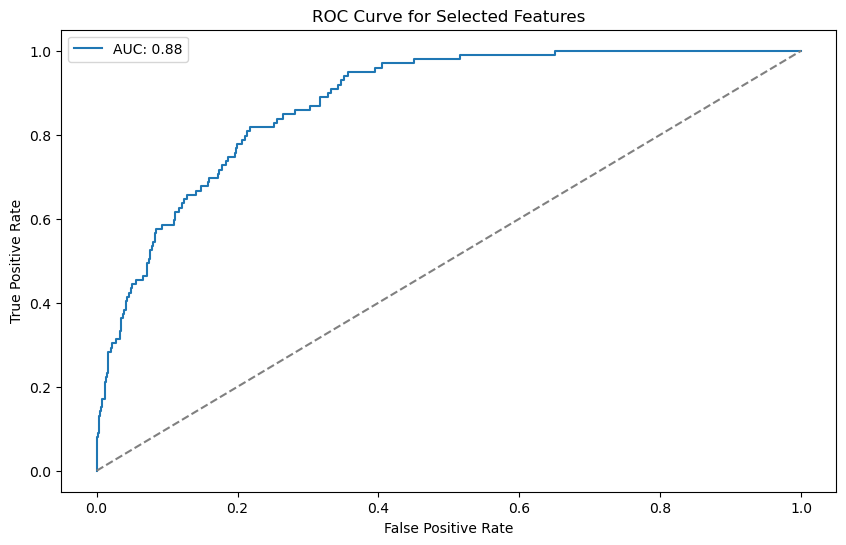

In [97]:
show_roc_curve(y_test, selected_pipeline_lr.predict_proba(X_test.select(indices))[:, 1], title="ROC Curve for Selected Features")

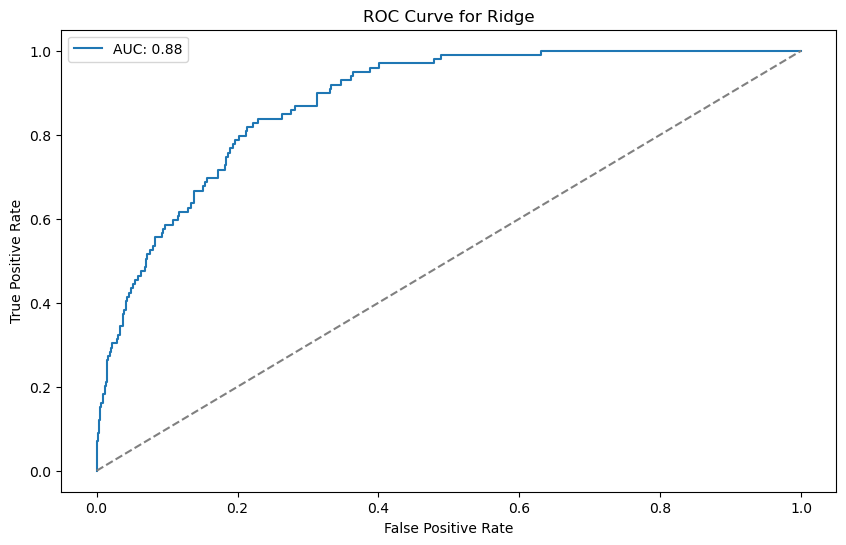

In [102]:
show_roc_curve(y_test, ridge_pl.predict_proba(X_test)[:, 1], title="ROC Curve for Ridge")

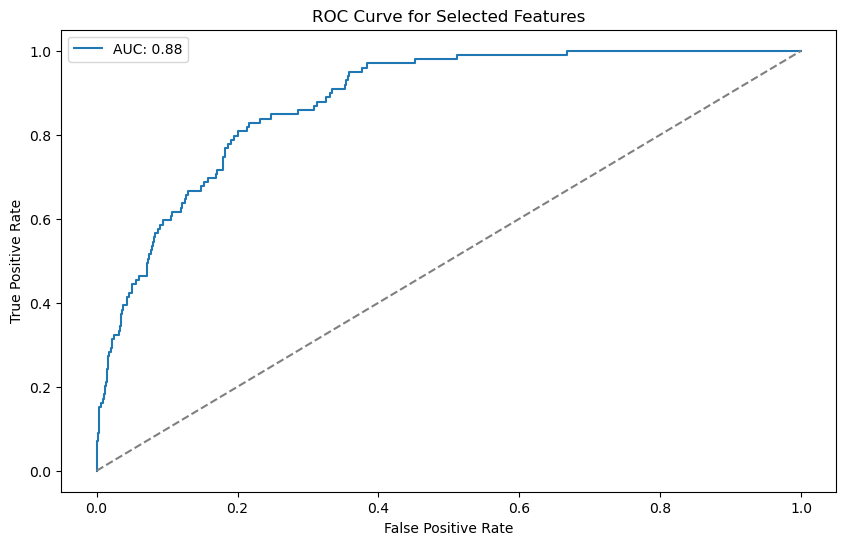

In [103]:
show_roc_curve(y_test, lasso_pl.predict_proba(X_test)[:, 1], title="ROC Curve for Selected Features")

I'll be so frfr these all look the same to me I do not have any analysis